In [1]:
try:
    import pytorch_lightning
except ImportError as e:
    print ('Installing PyTorch')
    !pip install pytorch-lightning==1.2.8  --quiet # module doesn't exist, deal with it.
    !pip install torchmetrics
    
try:
    import transformers
except ImportError as e:
    print ('Installing Transformers')
    !pip install transformers==4.10 --quiet --quiet # module doesn't exist, deal with it.


!pip install gdown

In [2]:
# for pep-8
!pip install nb_black
!pip install pycodestyle_magic
!pip install pycodestyle
!pip install flake8

In [1]:
%load_ext nb_black
%load_ext pycodestyle_magic

<IPython.core.display.Javascript object>

# Multi-class classification of text for emotion types detection using BERT and PyTorch

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for emotion types detection?

- Read the tutorial
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [2]:
import pandas as pd
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torchmetrics
import pytorch_lightning as pl
from torchmetrics.functional import accuracy,auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import json
import zipfile
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)


2022-11-11 17:34:43.196829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 17:34:43.294554: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 17:34:43.689026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:
2022-11-11 17:34:43.689313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

42

<IPython.core.display.Javascript object>

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 8.3.0

numpy       : 1.22.3
pandas      : 1.4.3
torch       : 1.11.0+cu113
transformers: 4.21.0



<IPython.core.display.Javascript object>

# Data Preprocessing
Pre-processs the GoEmotions dataset which is a corpus of carefully curated comments extracted from Reddit, with human annotations to 27 emotion categories or Neutral. Let's map datset according to 7 emotions. You can also try running the model on all emotions:

In [4]:
file_name = "data_light/go_emotions/train.tsv"

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv(file_name, sep="\t", header=None, names=["Text", "Class", "ID"])

<IPython.core.display.Javascript object>

In [6]:
df["List of classes"] = df["Class"].apply(lambda x: x.split(","))
df["Len of classes"] = df["List of classes"].apply(lambda x: len(x))

<IPython.core.display.Javascript object>

In [7]:
with open("data_light/go_emotions/ekman_mapping.json") as file:
    ekman_mapping = json.load(file)

<IPython.core.display.Javascript object>

In [8]:
emotion_file = open("data_light/go_emotions/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


<IPython.core.display.Javascript object>

In [9]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

<IPython.core.display.Javascript object>

In [10]:
df['Emotions'] = df['List of classes'].apply(idx2class)


<IPython.core.display.Javascript object>

In [11]:
def EmotionMapping(emotion_list):
    map_list = []

    for i in emotion_list:
        if i in ekman_mapping["anger"]:
            map_list.append("anger")
        if i in ekman_mapping["disgust"]:
            map_list.append("disgust")
        if i in ekman_mapping["fear"]:
            map_list.append("fear")
        if i in ekman_mapping["joy"]:
            map_list.append("joy")
        if i in ekman_mapping["sadness"]:
            map_list.append("sadness")
        if i in ekman_mapping["surprise"]:
            map_list.append("surprise")
        if i == "neutral":
            map_list.append("neutral")

    return map_list

<IPython.core.display.Javascript object>

In [12]:
df["Mapped Emotions"] = df["Emotions"].apply(EmotionMapping)

<IPython.core.display.Javascript object>

In [13]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df[i] = df['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)


<IPython.core.display.Javascript object>

In [14]:
df.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [15]:
df.drop(df[df['neutral'] == 1].index, inplace=True)

df.drop(df[df['disgust'] == 1].index, inplace=True)


<IPython.core.display.Javascript object>

In [16]:
df.drop(
    [
        "Class",
        "List of classes",
        "Len of classes",
        "Emotions",
        "Mapped Emotions",
        "neutral",
        "disgust",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

In [17]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "u.s": "america",
    "e.g": "for example",
}

punct = [
    ",",
    ".",
    '"',
    ":",
    ")",
    "(",
    "-",
    "!",
    "?",
    "|",
    ";",
    "'",
    "$",
    "&",
    "/",
    "[",
    "]",
    ">",
    "%",
    "=",
    "#",
    "*",
    "+",
    "\\",
    "•",
    "~",
    "@",
    "£",
    "·",
    "_",
    "{",
    "}",
    "©",
    "^",
    "®",
    "`",
    "<",
    "→",
    "°",
    "€",
    "™",
    "›",
    "♥",
    "←",
    "×",
    "§",
    "″",
    "′",
    "Â",
    "█",
    "½",
    "à",
    "…",
    "“",
    "★",
    "”",
    "–",
    "●",
    "â",
    "►",
    "−",
    "¢",
    "²",
    "¬",
    "░",
    "¶",
    "↑",
    "±",
    "¿",
    "▾",
    "═",
    "¦",
    "║",
    "―",
    "¥",
    "▓",
    "—",
    "‹",
    "─",
    "▒",
    "：",
    "¼",
    "⊕",
    "▼",
    "▪",
    "†",
    "■",
    "’",
    "▀",
    "¨",
    "▄",
    "♫",
    "☆",
    "é",
    "¯",
    "♦",
    "¤",
    "▲",
    "è",
    "¸",
    "¾",
    "Ã",
    "⋅",
    "‘",
    "∞",
    "∙",
    "）",
    "↓",
    "、",
    "│",
    "（",
    "»",
    "，",
    "♪",
    "╩",
    "╚",
    "³",
    "・",
    "╦",
    "╣",
    "╔",
    "╗",
    "▬",
    "❤",
    "ï",
    "Ø",
    "¹",
    "≤",
    "‡",
    "√",
]

punct_mapping = {
    "‘": "'",
    "₹": "e",
    "´": "'",
    "°": "",
    "€": "e",
    "™": "tm",
    "√": " sqrt ",
    "×": "x",
    "²": "2",
    "—": "-",
    "–": "-",
    "’": "'",
    "_": "-",
    "`": "'",
    "“": '"',
    "”": '"',
    "“": '"',
    "£": "e",
    "∞": "infinity",
    "θ": "theta",
    "÷": "/",
    "α": "alpha",
    "•": ".",
    "à": "a",
    "−": "-",
    "β": "beta",
    "∅": "",
    "³": "3",
    "π": "pi",
    "!": " ",
}

mispell_dict = {
    "colour": "color",
    "centre": "center",
    "favourite": "favorite",
    "travelling": "traveling",
    "counselling": "counseling",
    "theatre": "theater",
    "cancelled": "canceled",
    "labour": "labor",
    "organisation": "organization",
    "wwii": "world war 2",
    "citicise": "criticize",
    "youtu ": "youtube ",
    "Qoura": "Quora",
    "sallary": "salary",
    "Whta": "What",
    "narcisist": "narcissist",
    "howdo": "how do",
    "whatare": "what are",
    "howcan": "how can",
    "howmuch": "how much",
    "howmany": "how many",
    "whydo": "why do",
    "doI": "do I",
    "theBest": "the best",
    "howdoes": "how does",
    "mastrubation": "masturbation",
    "mastrubate": "masturbate",
    "mastrubating": "masturbating",
    "pennis": "penis",
    "Etherium": "Ethereum",
    "narcissit": "narcissist",
    "bigdata": "big data",
    "2k17": "2017",
    "2k18": "2018",
    "qouta": "quota",
    "exboyfriend": "ex boyfriend",
    "airhostess": "air hostess",
    "whst": "what",
    "watsapp": "whatsapp",
    "demonitisation": "demonetization",
    "demonitization": "demonetization",
    "demonetisation": "demonetization",
}

<IPython.core.display.Javascript object>

In [18]:
def clean_text(text):
    """Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers."""
    text = emoji.demojize(text)
    text = re.sub(r"\:(.*?)\:", "", text)
    text = str(text).lower()  # Making Text Lowercase
    text = re.sub("\[.*?\]", "", text)
    # The next 2 lines remove html text
    text = BeautifulSoup(text, "lxml").get_text()
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text


def clean_contractions(text, mapping):
    """Clean contraction using contraction mapping"""
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if "" + word + "" in text:
            text = text.replace("" + word + "", "" + mapping[word] + "")
    # Remove Punctuations
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text


def clean_special_chars(text, punct, mapping):
    """Cleans special characters present(if any)"""
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f" {p} ")

    specials = {"\u200b": " ", "…": " ... ", "\ufeff": "", "करना": "", "है": ""}
    for s in specials:
        text = text.replace(s, specials[s])

    return text


def correct_spelling(x, dic):
    """Corrects common spelling errors"""
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x


def remove_space(text):
    """Removes awkward spaces"""
    # Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)


def text_preprocessing_pipeline(text):
    """Cleaning and parsing the text."""
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

<IPython.core.display.Javascript object>

In [19]:
df.reset_index(drop=True).to_csv("data_light/go_emotions/train.csv", index=False)

<IPython.core.display.Javascript object>

In [20]:
df = df.drop(columns=["ID"], axis=1)

<IPython.core.display.Javascript object>

In [21]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [22]:
print(df.shape)

(28427, 6)


<IPython.core.display.Javascript object>

In [23]:
df.head()

,Text,anger,fear,joy,sadness,surprise
0,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0
1,To make her feel threatened,0,1,0,0,0
2,Dirty Southern Wankers,1,0,0,0,0
3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,0,0,0,0,1
4,Yes I heard abt the f bombs! That has to be wh...,0,0,1,0,0


<IPython.core.display.Javascript object>

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<IPython.core.display.Javascript object>

### Split into training and validation

Let's divide data into training,validation :

In [25]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape, val_df.shape

((22741, 6), (5686, 6))

<IPython.core.display.Javascript object>

# Data Analysis

Let's look at the distribution of the labels:

In [26]:
cols = df.columns.tolist()[1:]


<IPython.core.display.Javascript object>

In [27]:
cols

['anger', 'fear', 'joy', 'sadness', 'surprise']

<IPython.core.display.Javascript object>

<AxesSubplot:>

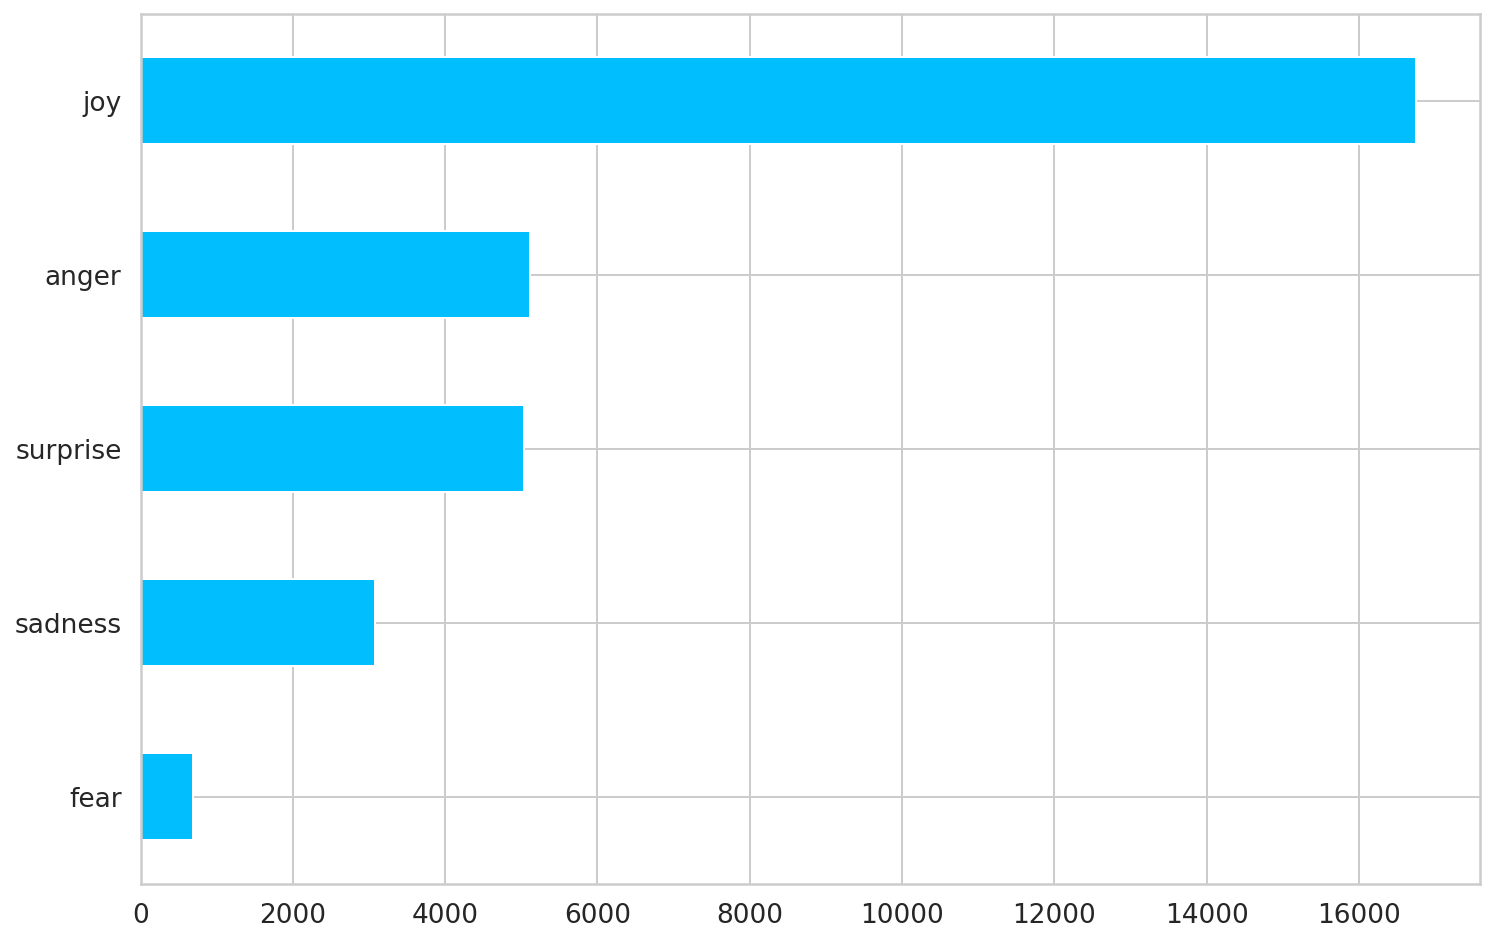

<IPython.core.display.Javascript object>

In [28]:
df[cols].sum().sort_values().plot(kind="barh")

## Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [29]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

<IPython.core.display.Javascript object>

In [30]:
df.columns

Index(['Text', 'anger', 'fear', 'joy', 'sadness', 'surprise'], dtype='object')

<IPython.core.display.Javascript object>

In [31]:
sample_row = df.iloc[20]
sample_comment = sample_row.Text
sample_labels = sample_row[cols]

print(sample_comment)
print()
print(sample_labels.to_dict())

All sounds possible except the key, I can't see how it was missed in the first search. 

{'anger': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 1}


<IPython.core.display.Javascript object>

In [32]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

<IPython.core.display.Javascript object>

In [33]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

<IPython.core.display.Javascript object>

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [34]:
encoding["input_ids"].squeeze()[:50]

tensor([ 101, 1398, 3807, 1936, 2589, 1103, 2501,  117,  146, 1169,  112,  189,
        1267, 1293, 1122, 1108, 4007, 1107, 1103, 1148, 3403,  119,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

<IPython.core.display.Javascript object>

In [35]:
encoding["attention_mask"].squeeze()[:50]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

<IPython.core.display.Javascript object>

We can also inverse the tokenization and get back the words from the token ids:

In [36]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:50])

['[CLS]', 'All', 'sounds', 'possible', 'except', 'the', 'key', ',', 'I', 'can', "'", 't', 'see', 'how', 'it', 'was', 'missed', 'in', 'the', 'first', 'search', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


<IPython.core.display.Javascript object>

BERT use three embeddings to compute the input representations. They are token embeddings, segment embeddings and position embeddings. “CLS” is the reserved token to represent the start of sequence while “SEP” separate segment (or sentence)

In [37]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:100])

['[CLS]', 'All', 'sounds', 'possible', 'except', 'the', 'key', ',', 'I', 'can', "'", 't', 'see', 'how', 'it', 'was', 'missed', 'in', 'the', 'first', 'search', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


<IPython.core.display.Javascript object>

We can see that when we tried to see 100 tokens, it appended 'PAD' as total number of tokens were less than 100. 

We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [38]:
token_counts = []

for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(row["Text"], max_length=512, truncation=True))
    token_counts.append(token_count)

<IPython.core.display.Javascript object>

In [39]:
train_df.columns

Index(['Text', 'anger', 'fear', 'joy', 'sadness', 'surprise'], dtype='object')

<IPython.core.display.Javascript object>

(0.0, 250.0)

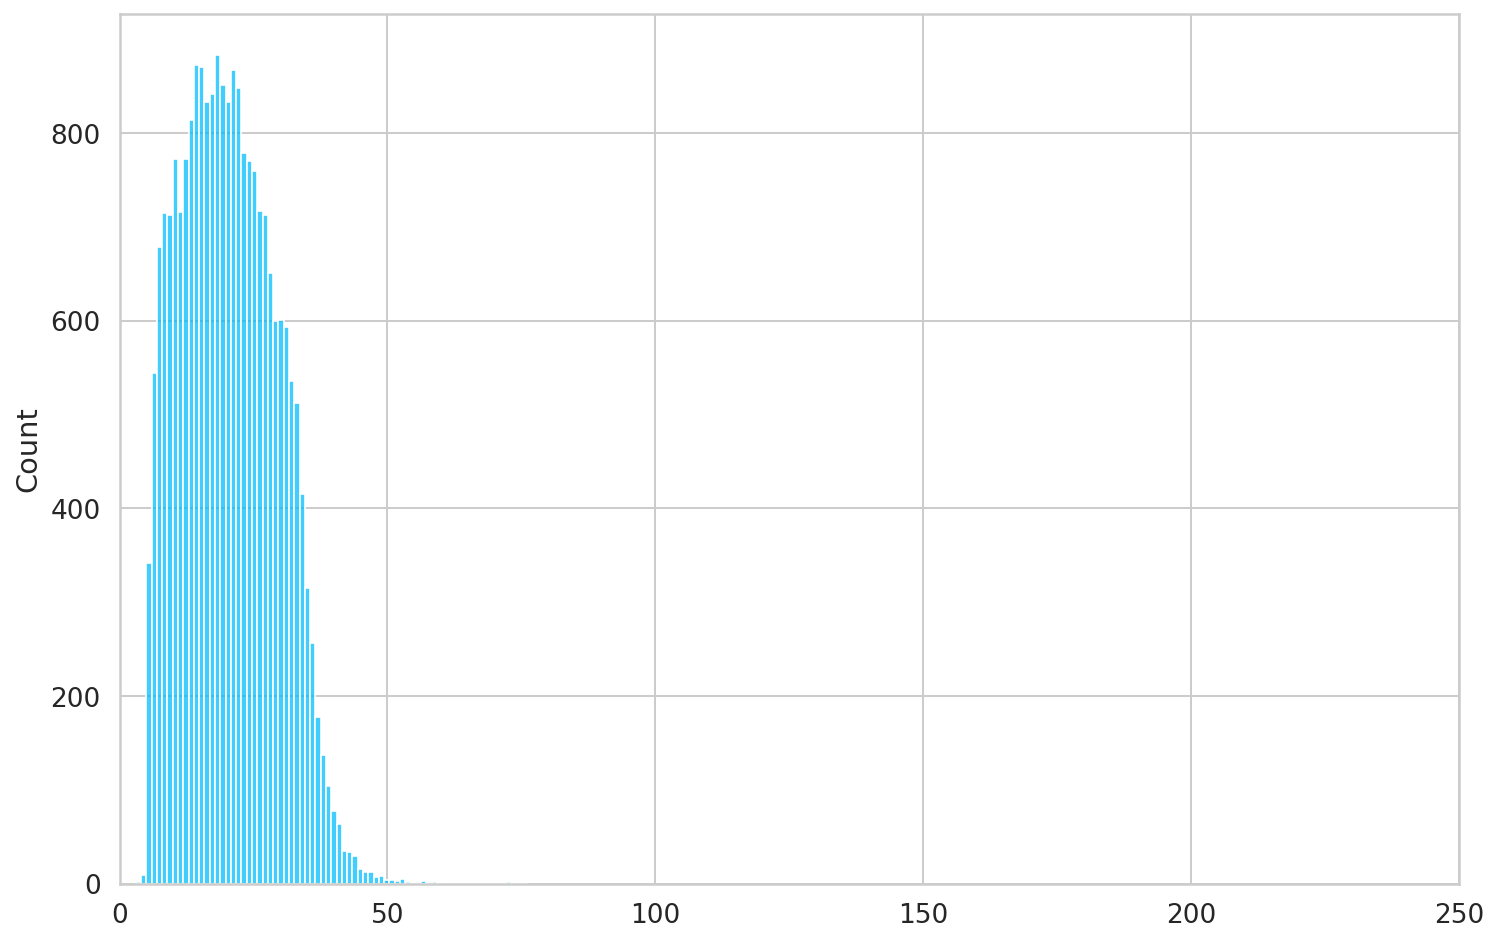

<IPython.core.display.Javascript object>

In [40]:
sns.histplot(token_counts)
plt.xlim([0, 250])

Most of the comments contain less than 50 tokens or more than 70. So, we'll stick with the limit of 70.

In [41]:
MAX_TOKEN_COUNT = 70

<IPython.core.display.Javascript object>

Let's apply the tokenization process to whole dataset:

In [42]:
class EmotionsCommentsDataset(Dataset):
    def __init__(
        self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        comment_text = data_row.Text
        labels = data_row[cols]

        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return dict(
            comment_text=comment_text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels),
        )

<IPython.core.display.Javascript object>

Let's have a look at a sample item from the dataset:

In [43]:
train_dataset = EmotionsCommentsDataset(
    train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[2]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

<IPython.core.display.Javascript object>

In [44]:
sample_item["comment_text"]

"Wow! Never thought of it this way but that's a REALLY good point."

<IPython.core.display.Javascript object>

In [45]:
sample_item["labels"]

tensor([0., 0., 1., 0., 1.])

<IPython.core.display.Javascript object>

In [46]:
sample_item["input_ids"].shape

torch.Size([70])

<IPython.core.display.Javascript object>

Let's load the BERT model and pass a sample of batch data through:

In [47]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

In [48]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=4, num_workers=16)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([4, 70]), torch.Size([4, 70]))

<IPython.core.display.Javascript object>

In [49]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

<IPython.core.display.Javascript object>

In [50]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([4, 70, 768]), torch.Size([4, 768]))

<IPython.core.display.Javascript object>

The `768` dimension comes from the BERT hidden size:

In [51]:
bert_model.config.hidden_size

768

<IPython.core.display.Javascript object>

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [52]:
class EmotionCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = EmotionsCommentsDataset(
            self.train_df, self.tokenizer, self.max_token_len
        )

        self.test_dataset = EmotionsCommentsDataset(
            self.test_df, self.tokenizer, self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=16
        )

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=16)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=16)

<IPython.core.display.Javascript object>

In [53]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = EmotionCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)


<IPython.core.display.Javascript object>

## Model Architecure

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):

In [54]:
class EmotionCommentTagger(pl.LightningModule):
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log(
            "train_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=False
        )
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log(
            "val_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=False
        )
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log(
            "test_loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=False
        )
        return loss

    def training_epoch_end(self, outputs):

        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)

        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)

        for i, name in enumerate(cols):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(
                f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch
            )

    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=2e-5)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )

        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step")
        )

<IPython.core.display.Javascript object>

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [55]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]["lr"])

/home/experts-vision/anaconda3/envs/py38_3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

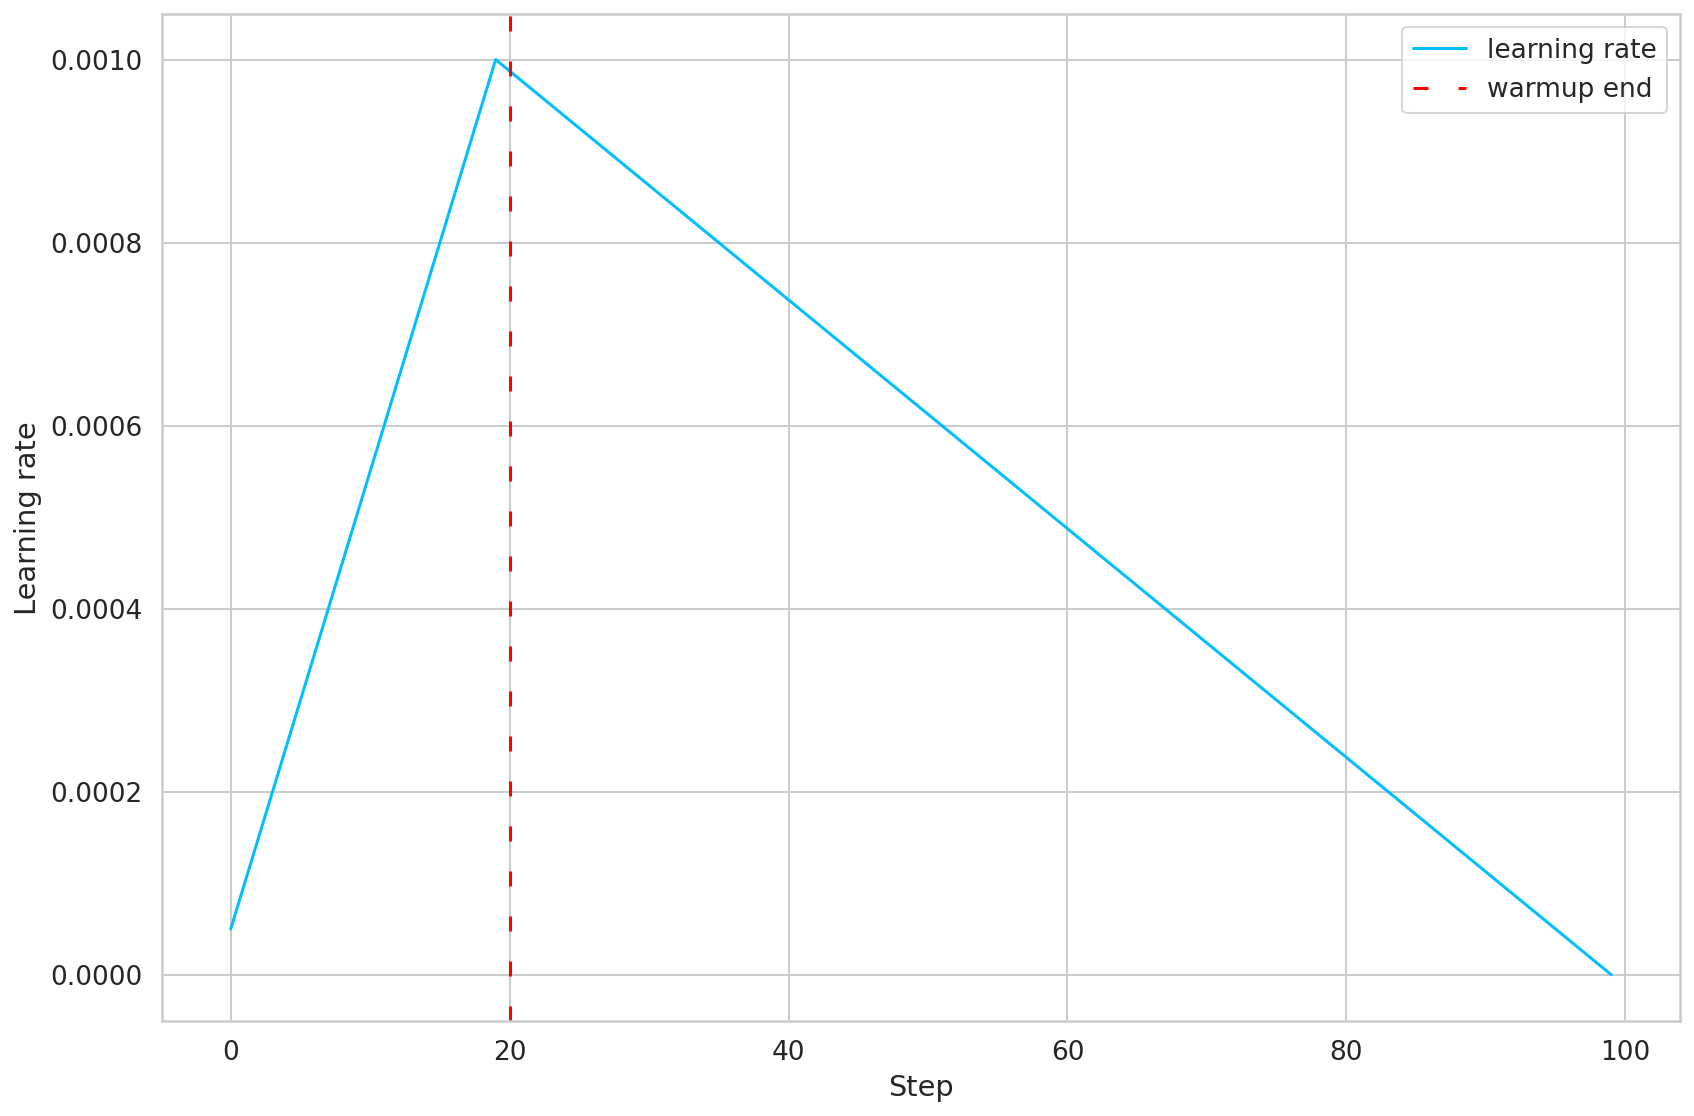

<IPython.core.display.Javascript object>

In [56]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout()

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [57]:
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

<IPython.core.display.Javascript object>

We'll use a fifth of the training steps for a warm-up:

In [58]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(3790, 18950)

<IPython.core.display.Javascript object>

We can now create an instance of our model:

In [59]:
model = EmotionCommentTagger(
    n_classes=len(cols),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [60]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
    [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor([1.0, 0.0, 0.0, 0.0, 1.0, 0.0])

<IPython.core.display.Javascript object>

In [61]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

<IPython.core.display.Javascript object>

In [62]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

<IPython.core.display.Javascript object>

We can use the same approach to calculate the loss of the predictions:

In [63]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5729, 0.5133, 0.3392, 0.3788, 0.5033],
        [0.5466, 0.5016, 0.3567, 0.3800, 0.5055],
        [0.5731, 0.5074, 0.3410, 0.3679, 0.5174],
        [0.5497, 0.5143, 0.3682, 0.3852, 0.5016]], grad_fn=<SigmoidBackward0>)

<IPython.core.display.Javascript object>

In [64]:
criterion(predictions, sample_batch["labels"])

tensor(0.7011, grad_fn=<BinaryCrossEntropyBackward0>)

<IPython.core.display.Javascript object>

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$


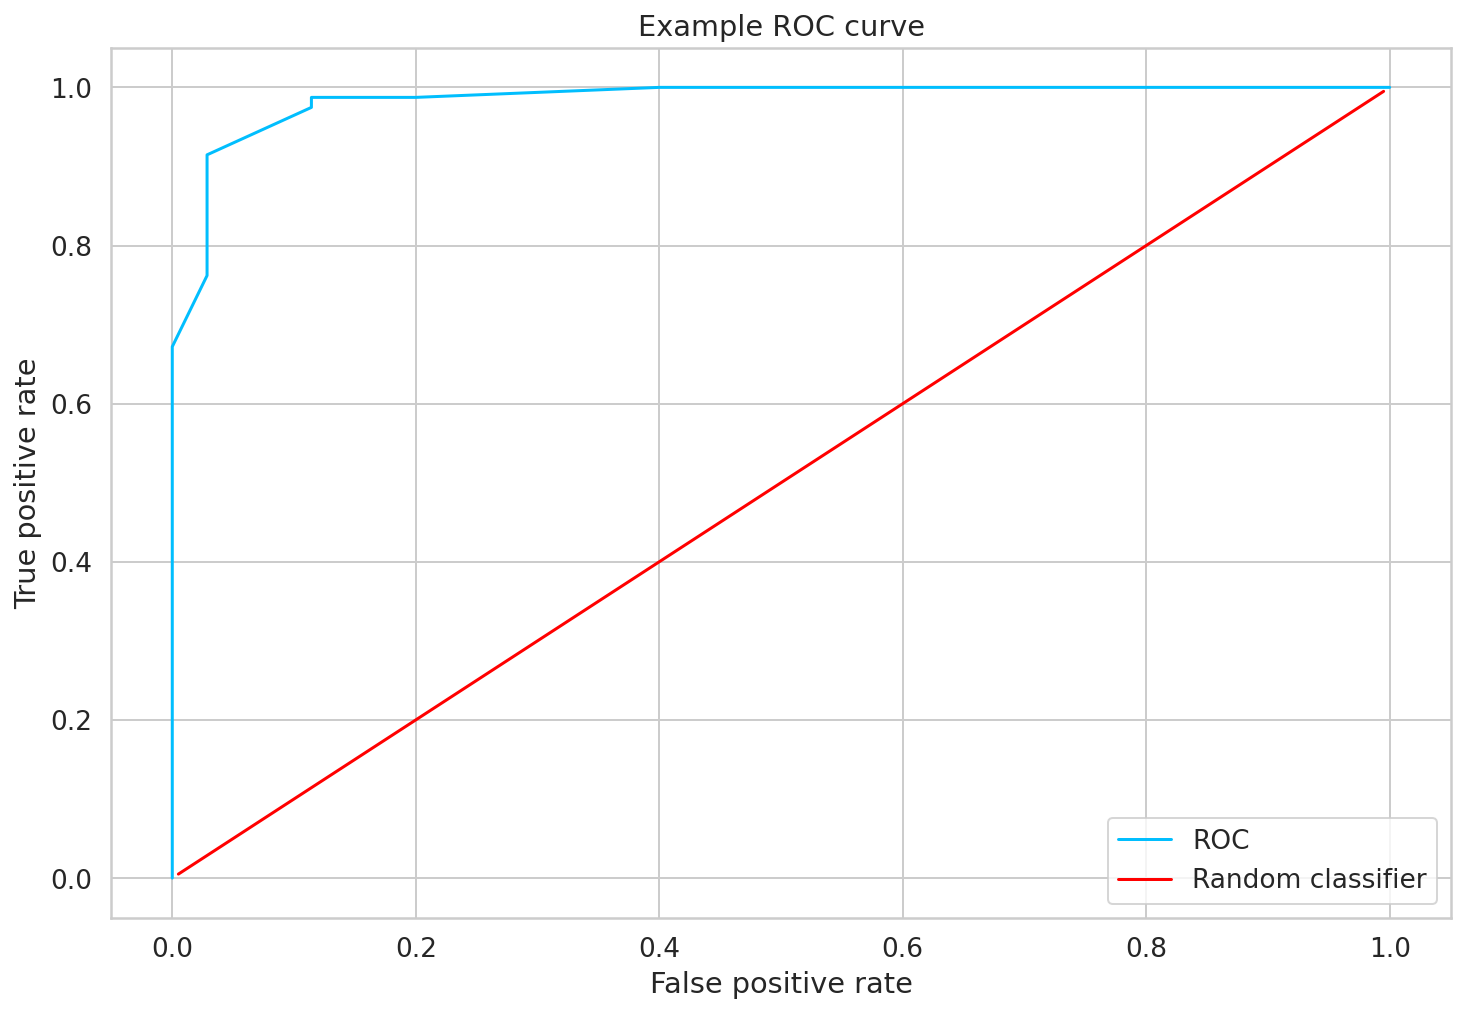

<IPython.core.display.Javascript object>

In [65]:
from sklearn import metrics

fpr = [0.0, 0.0, 0.0, 0.02857143, 0.02857143, 0.11428571, 0.11428571, 0.2, 0.4, 1.0]

tpr = [
    0.0,
    0.01265823,
    0.67202532,
    0.76202532,
    0.91468354,
    0.97468354,
    0.98734177,
    0.98734177,
    1.0,
    1.0,
]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot(
    [0.05, 0.95],
    [0.05, 0.95],
    transform=ax.transAxes,
    label="Random classifier",
    color="red",
)
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show()

## Training

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

# Don't want to wait? Uncomment the next cell and download my pre-trained model in the prediction part:

In [78]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

<IPython.core.display.Javascript object>

Log the progress in TensorBoard:

In [79]:
path = "data/lightning_logs_bert_multilabel/emotions-comments"
file_name = "data/lightning_logs_bert_multilabel"
isExist = os.path.exists(file_name)
if not isExist:

    # Create a new directory because it does not exist
    os.makedirs(path)

<IPython.core.display.Javascript object>

In [80]:
logger = TensorBoardLogger(
    "data/lightning_logs_bert_multilabel", name="emotions-comments"
)

<IPython.core.display.Javascript object>

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [81]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

<IPython.core.display.Javascript object>

We can start the training process:

In [82]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30,
)

/home/experts-vision/anaconda3/envs/py38_3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f46e71d42e0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f46e71d42e0>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<IPython.core.display.Javascript object>

In [83]:
TOKENIZERS_PARALLELISM = False

<IPython.core.display.Javascript object>

In [84]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.256   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/experts-vision/anaconda3/envs/py38_3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<IPython.core.display.Javascript object>

In [85]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5919219255447388
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5919219255447388}]

<IPython.core.display.Javascript object>

# Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let's load the best version (according to the validation loss) of our model:

In [94]:
path = "data"
file_name = "data/lightning_logs_bert_multilabel"
if os.path.exists(file_name):
    pass
else:
    isExist = os.path.exists(path)
    if not isExist:

        # Create a new directory because it does not exist
        os.makedirs(path)
        print("The new directory is created!")
    !gdown  -O 'data/lightning_logs_bert_multilabel​.zip' 1H7lYGKKkJVmQlLexpIfYiQIyj256eJXk
    with zipfile.ZipFile("data/lightning_logs_bert_multilabel.zip", "r") as zip_ref:
        zip_ref.extractall("data/lightning_logs_bert_multilabel.zip")

<IPython.core.display.Javascript object>

In [87]:
trained_model = EmotionCommentTagger.load_from_checkpoint(
    checkpoint_path="data/lightning_logs_bert_multilabel/emotions-comments/version_2/checkpoints/epoch=3-step=7584.ckpt",
    n_classes=len(cols),
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample (totally fictional) comment:

In [88]:
test_comment = "I hope you’re okay! I’m so sorry that happened. I’m glad I don’t work in gastown anymore"

encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(cols, test_prediction):
    print(f"{label}: {prediction}")

anger: 0.0120647381991148
fear: 0.005505742970854044
joy: 0.9620158672332764
sadness: 0.617685079574585
surprise: 0.015234323218464851


<IPython.core.display.Javascript object>

Looks good. This one is pretty clean. We'll reduce the noise of the predictions by thresholding (0.5) them. We'll take only tag predictions above (or equal) to the threshold. Let's try:

In [89]:
THRESHOLD = 0.5

test_comment = "You are such a loser! You'll regret everything you've done to me!"
encoding = tokenizer.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(cols, test_prediction):
    if prediction < THRESHOLD:
        continue
    print(f"{label}: {prediction}")

sadness: 0.8875961303710938


<IPython.core.display.Javascript object>

I definitely agree with those tags. It looks like our model is doing something reasonable, on those two examples.

# Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = trained_model.to(device)

val_dataset = EmotionsCommentsDataset(val_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

predictions = []
labels = []

for item in tqdm(val_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device),
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/5686 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

One simple metric is the accuracy of the model:

In [95]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9154)

<IPython.core.display.Javascript object>

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag:

In [96]:
print("AUROC per tag")
for i, name in enumerate(cols):
    tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
    print(f"{name}: {tag_auroc}")

AUROC per tag
anger: 0.9242473840713501
fear: 0.9614473581314087
joy: 0.9447811841964722
sadness: 0.9298059940338135
surprise: 0.9191710352897644


<IPython.core.display.Javascript object>

Very good results, but just before we go party, let's check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [97]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(y_true, y_pred, target_names=cols, zero_division=0))

              precision    recall  f1-score   support

       anger       0.66      0.73      0.69      1035
        fear       0.68      0.64      0.66       133
         joy       0.89      0.90      0.89      3383
     sadness       0.68      0.64      0.66       594
    surprise       0.80      0.61      0.69       980

   micro avg       0.81      0.79      0.80      6125
   macro avg       0.74      0.70      0.72      6125
weighted avg       0.81      0.79      0.80      6125
 samples avg       0.82      0.81      0.81      6125



<IPython.core.display.Javascript object>

That gives us a much more realistic picture of the overall performance. The model makes mistakes on the tags will low amounts of examples. What can you do about it?

# Summary

Great job, you have a model that can tell (to some extent) if a text is toxic (and what kind) or not! Fine-tuning modern pre-trained Transformer models allow you to get high accuracy on a variety of NLP tasks with little compute power and small datasets.

- Read the tutorial
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In this tutorial, you'll learned how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Can you increase the accuracy of the model? How about better parameters or different learning rate scheduling? Let me know in the comments.